In [118]:
import pickle 
import time
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import spacy

from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

from parsing import process_html_files
from io_util import read_text_file

%matplotlib inline  

# project paths
html_dir = 'htmls'
text_baseline_dir = 'text_baseline'
text_tuned_dir = 'text_tuned'

nlp_de = spacy.load('de_core_news_sm')

# basic setup
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
cv_scoring = 'average_precision'

def pickle_to_file(model, name):
    with open('{0}-{1}.pickle'.format(name, time.strftime("%Y%m%d_%H%M%S")), 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Q: How did you decide to handle this amount of data

As there are only 148 html files, I've decided to batch process them in a separate step and cache the results on disk.
The processing is defined in the parsing.py module in two variants:
1. Baseline text extraction: remove only the header/footer and navigation by html tags, remove hidden elements (with style containing "display: none" or "visibility: hidden"), consider the rest as article text. Saved in the text_baseline folder.
2. "Tuned" text extraction: baseline + remove elements with classes or ids containing keywords like 'menu', 'header', 'footer', etc (see parsing.parse_html_tuned). Saved in the text_tuned folder.

The two approaches will be compared further.

In [2]:
%%time
# populate both text folders
process_html_files(html_dir)

Wall time: 22.8 s


## Train data investigation

In [3]:
print(train.sample(10))
print('Num train samples: {0}'.format(len(train.index)))
print('Label proportions:') 
print(train['label'].value_counts(normalize=True) * 100)

                                                  url  doc_id  label
88       http://www.thoraxklinik-heidelberg.de/?id=42     131      2
24  http://www.alb-fils-kliniken.de/radiologie-und...      30      2
84  http://www.sfh-muenster.de/unsere-kompetenzen/...     126      2
57  http://www.klinikum-guetersloh.de/kliniken/fra...      90      1
2   http://klinikum-braunschweig.de/info.php/?id_o...       4      1
32  http://www.ctk.de/hu/klinikum/kliniken-zentren...      44      2
20  http://rotkreuzklinikum-muenchen.de/medizin-un...      26      2
86  http://www.thoraxklinik-heidelberg.de/?fs=0&id...     129      2
83  http://www.sbk-vs.de/de/medizin/leistungen-und...     125      1
3   http://klinikum-braunschweig.de/info.php/?id_o...       5      1
Num train samples: 100
Label proportions:
2    59.0
1    32.0
3     9.0
Name: label, dtype: float64


The dataset is both very small and very unbalanced -> danger of overfitting, simpler approaches are likely to perform better.
Considering how little data there is, we're not likely to be able to automatically extract a lot of insight from it, and will have to rely on prior knowledge as much as possible.

### Getting the texts

In [4]:
def load_text(df):
    res = df.apply(
        lambda row: pd.Series(
            [
                row.doc_id, 
                read_text_file('text_baseline', '{0}.txt'.format(row.doc_id)),
                read_text_file('text_tuned', '{0}.txt'.format(row.doc_id))
            ],
            index=['doc_id', 'text_baseline', 'text_tuned']
        ), 
        axis=1, result_type='expand'
    )
    res['baseline_char_count'] = res['text_baseline'].apply(len)
    res['tuned_char_count'] = res['text_tuned'].apply(len)
    return res

train_text = load_text(train)
test_text = load_text(test)

## Text extraction investigation

In [5]:
# checking if the tuned text extraction reduced text size
print(train_text[['doc_id', 'baseline_char_count', 'tuned_char_count']].sort_values(by='tuned_char_count').head(10))
# seems like for a few websites the "tuning" removes too much

size_diff = train_text['baseline_char_count'] - train_text['tuned_char_count']
tuned_ratio = train_text['tuned_char_count'] / train_text['baseline_char_count']
print('Size reduction from "tuned" approach excluding likely erroneous cases: {0:.2f}%'.format(
    size_diff[tuned_ratio > 0.1].sum() / train_text['baseline_char_count'][tuned_ratio > 0.1].sum() * 100))

    doc_id  baseline_char_count  tuned_char_count
80     120                 5070                68
99     146                 9526                73
30      41                 9206               207
21      27                38457               209
7       10                 1843               521
67     102                  730               576
51      81                 1063               801
55      88                 1162               900
49      79                 1540               970
84     126                 1152              1061
Size reduction from "tuned" approach excluding likely erroneous cases: 16.46%


Overall the "tuned" parser results in completely nuking the content of a few pathological sites, but a size reduction of ~15% for a typical page. Could be helpful to reduce storage costs and improve the performance of the following steps (especially the costly spaCy pre-processing); but would need more refinement and more experimenting with larger data. 

### For now I will drop the "tuned" parser from further consideration and leave it for possible future enhancements, focusing on the "baseline" texts for classification.

# Tumorboard info detection outline

I think that for this problem it makes most sense to perform document classification in two stages: 
1. Classify the documents into irrelevant (class 1) and containing any info about tumorboards (classes 2 and 3 together).
2. For the second group perform further classification with a second classifier trained to distinguish between classes 2 and 3.

I will assume that for this problem we are more interested in high classifier precision, as I expect most of the real data to be examples of class 1, and presenting the eventual end-user with a lot of irrelevant info would presumably be detrimental.

For both stages the model training process will be similar: 
1. Do a train-test split of the dataset,
2. Perform hyperparameter selection for the feature extraction stage and the classifier using a nested cross-validation on the training split, using average precision for model comparison,
3. Compare final models on the test split, selecting a decision rule leading to the "best" precision/recall combination ("best" in the sense of personal preference, as I'm unfamiliar with the details of the real business problem).

### Re-labeling the data

In [6]:
# compute first stage labels
train['label_first_stage'] = (train['label'] > 1).astype(int)
print(train['label_first_stage'].value_counts(normalize=True) * 100)
# here 0 is the 'irrelevant' class, 1 is 'has any info' class (positive)

# compute second stage labels
train_second_stage = train[train['label'] > 1].copy()
train_second_stage['label_second_stage'] = (train_second_stage['label'] == 3).astype(int)
print('Second stage train dataset size: ', train_second_stage.shape[0])
print(train_second_stage['label_second_stage'].value_counts(normalize=True) * 100)
# here 0 is the 'medium confidence' class, 1 is 'high condifence' class (positive)

1    68.0
0    32.0
Name: label_first_stage, dtype: float64
Second stage train dataset size:  68
0    86.764706
1    13.235294
Name: label_second_stage, dtype: float64


### Pre-processing the text data

As the first part of feature selection the raw text is processed using spaCy and a pre-trained German language model:
the text is tokenized and lemmatized, punctuation and other non-alphabetic tokens are removed, and recognized named entities are removed as well (as it seems unreasonable to depend on them for classification). I merge the synonyms "Tumorboard" and "Tumorkonferenz" manually to prevent further feature extraction steps from disregarding the first of them, as it occurs in much fewer documents.

In [244]:
%%time
def preprocess_spacy(string):
    def try_replace(lemma):  # ad-hoc synonym replacement
        lemma_lw = lemma.lower()
        if lemma_lw == 'tumorboard':
            return 'tumorkonferenz'
        elif lemma_lw == 'tumorboards':
            return 'tumorkonferenzen'
        else:
            return lemma
    doc = nlp_de(string)
    return ' '.join([try_replace(token.lemma_) for token in doc if not token.is_stop and not token.is_punct and token.is_alpha and not token.ent_type])

train_text['text_baseline_cleaned'] = train_text['text_baseline'].apply(lambda x: preprocess_spacy(x))
test_text['text_baseline_cleaned'] = test_text['text_baseline'].apply(lambda x: preprocess_spacy(x))

Wall time: 24.5 s


## Feature extraction approach

I consider two approaches to feature extraction from the pre-processed text data: term counts and TF-IDF-weighted term counts (CountVectorizer and TfidfVectorizer respectively). The main concern was reducing the feature count, since there are way too few training samples to meaningfully estimate the coefficients for so many features. The reduction is done via discarding the terms occurring in too few documents, with the cutoff point as the hyperparameter to be determined further (to be selected from between 10% to 35% of the documents). The choice between CountVectorizer and TfidfVectorizer is a hyperparameter as well.

In [12]:
print('Num_features if terms occurring in fewer that 1% of documents are removed: ', 
      CountVectorizer(min_df=0.01).fit_transform(train_text['text_baseline_cleaned']).shape[1])
print('Num_features if terms occurring in fewer that 10% of documents are removed: ', 
      CountVectorizer(min_df=0.10).fit_transform(train_text['text_baseline_cleaned']).shape[1])
print('Num_features if terms occurring in fewer that 35% of documents are removed: ',
      CountVectorizer(min_df=0.35).fit_transform(train_text['text_baseline_cleaned']).shape[1])
test_count_vec = CountVectorizer(min_df=0.35)
test_count_vec.fit_transform(train_text['text_baseline_cleaned'])
print('A possible set of features when removing terms occurring in fewer that 35% of documents: ', 
      sorted(test_count_vec.vocabulary_.keys()))

Num_features if terms occurring in fewer that 1% of documents are removed:  11679
Num_features if terms occurring in fewer that 10% of documents are removed:  524
Num_features if terms occurring in fewer that 35% of documents are removed:  51
A possible set of features when removing terms occurring in fewer that 35% of documents:  ['abteilung', 'ambulant', 'arzt', 'behandlung', 'bereich', 'besprechen', 'betreuung', 'bieten', 'chirurgie', 'diagnostik', 'diagnostisch', 'erhalten', 'erkrankung', 'finden', 'gemeinsam', 'information', 'innere', 'interdisziplinär', 'karriere', 'klinik', 'klinikum', 'klinisch', 'kontakt', 'med', 'medizin', 'medizinisch', 'mein', 'modern', 'onkologie', 'patient', 'pflege', 'presse', 'radiologie', 'rahmen', 'schwerpunkt', 'sprechstunde', 'stehen', 'strahlentherapie', 'studie', 'team', 'telefon', 'therapie', 'tumor', 'tumorkonferenz', 'tumorkonferenzen', 'verfahren', 'verfügung', 'versorgung', 'weiterbildung', 'wichtig', 'zentrum']


### Model selection setup

In [84]:
class ClfSwitcher(BaseEstimator):
    def __init__(
        self, 
        estimator = LogisticRegression(),
    ):
        """
        A custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)
    
    
def nested_cv(x, y, model, param_dist, scoring, n_iter, outer_cv, inner_cv):
    rs = RandomizedSearchCV(model, param_dist, verbose=1, scoring=scoring, cv=inner_cv, n_iter=n_iter, n_jobs=-1)
    rs.fit(x, y)
    scores = cross_val_score(rs, x, y, cv=outer_cv)
    return ((rs.best_estimator_, rs.best_score_, rs.best_params_), scores)

def pipeline_w_param_dist(clf=None):
    count_vec = CountVectorizer(max_features=None, ngram_range=(1,1))
    tf_idf = TfidfVectorizer(max_features=None, ngram_range=(1,1))
    lr = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
    rf = RandomForestClassifier(n_jobs=1, class_weight='balanced')

    pipe = Pipeline(steps=[('features', count_vec), ('clf', ClfSwitcher())])

    param_dist = [
        {
            'features': [count_vec, tf_idf],
            'features__min_df': scipy.stats.uniform(0.1, 0.25),
            'clf__estimator': [lr],
            'clf__estimator__C': scipy.stats.loguniform(1e-1, 1e+3)
        },
        {
            'features': [count_vec, tf_idf],
            'features__min_df': scipy.stats.uniform(0.1, 0.25),
            'clf__estimator': [rf],
            'clf__estimator__n_estimators': scipy.stats.randint(10, 351)
        }
    ]
    dist_selected = param_dist if clf is None else (param_dist[0] if clf == 'lr' else param_dist[1])
    return pipe, dist_selected

def hyperparam_search(x, y, model, param_dist, outer_cv, inner_cv, n_iter=300):
    return nested_cv(x, y, model, param_dist, cv_scoring, n_iter, outer_cv, inner_cv)

## First stage classification

For the first stage I'll try out logistic regression and random forests classifiers (simple vs somewhat complicated model). 

I use logistic regression with L1 regularization in hope that it will help with culling irrelevant features. Regularization strength is determined during hyperparameter search.

For the random forest the only considered hyperparameter is the number of estimators in the ensemble, selected between 10 and 350. 

In [14]:
X_st_1 = train_text['text_baseline_cleaned']
y_st_1 = train['label_first_stage']
X_train_st_1, X_test_st_1, y_train_st_1, y_test_st_1 = train_test_split(X_st_1, y_st_1, test_size=0.20,
                                                                        stratify=y_st_1, random_state=123)

outer_stage_1 = StratifiedKFold(n_splits = 10, shuffle = True)
inner_stage_1 = StratifiedKFold(n_splits = 5, shuffle = True)

res_lr = hyperparam_search(X_train_st_1, y_train_st_1,
                           *pipeline_w_param_dist('lr'),
                           outer_stage_1, inner_stage_1, 300)
print(res_lr)

res_rf = hyperparam_search(X_train_st_1, y_train_st_1,
                           *pipeline_w_param_dist('rf'),
                           outer_stage_1, inner_stage_1, 300)
print(res_rf)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1456 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1477 out of 1500 | elapsed:   14.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1477 out of 1500 | elapsed:   11.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.0s finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1477 out of 1500 | elapsed:   12.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1477 out of 1500 | elapsed:   12.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.6s finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1477 out of 1500 | elapsed:   11.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1477 out of 1500 | elapsed:   12.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.4s finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1477 out of 1500 | elapsed:   11.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


((Pipeline(memory=None,
         steps=[('features',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=0.2303735570747031,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 ClfSwitcher(estimator=LogisticRegression(C=0.4912747744935402,
                                                          class_weight='balanced',
                                                          dual=False,
                                                       

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.3min finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.2min finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.3min finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.3min finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.2min finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.3min finished


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.2min finished


((Pipeline(memory=None,
         steps=[('features',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=0.34276111611043986, ngram_range=(1, 1),
                                 norm='l2', preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=...
                                                              ccp_alpha=0.0,
                                                              class_weight='balanced',
                                                              criterion='gini',
                                                              max_depth=None,
            

In [16]:
print('LR AP: {0:.3f} +- {1:.3f}'.format(res_lr[1].mean(), res_lr[1].std()))
print('RF AP: {0:.3f} +- {1:.3f}'.format(res_rf[1].mean(), res_rf[1].std()))

LR AP: 0.924 +- 0.047
RF AP: 0.938 +- 0.070


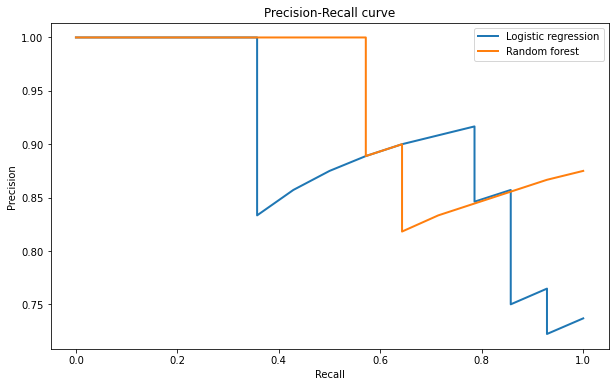

Logistric regression PR table:
         thr  precision    recall
0   0.204803   0.736842  1.000000
1   0.266389   0.722222  0.928571
2   0.297521   0.764706  0.928571
3   0.346902   0.750000  0.857143
4   0.491119   0.800000  0.857143
5   0.515657   0.857143  0.857143
6   0.593193   0.846154  0.785714
7   0.599773   0.916667  0.785714
8   0.649553   0.900000  0.642857
9   0.703681   0.888889  0.571429
10  0.763312   0.875000  0.500000
11  0.832071   0.857143  0.428571
12  0.890117   0.833333  0.357143
13  0.901695   1.000000  0.357143
14  0.928074   1.000000  0.285714
15  0.967020   1.000000  0.214286
16  0.983516   1.000000  0.142857
17  0.996118   1.000000  0.071429
18  1.000000   1.000000  0.000000
Random forest PR table:
         thr  precision    recall
0   0.612403   0.875000  1.000000
1   0.635659   0.866667  0.928571
2   0.643411   0.833333  0.714286
3   0.651163   0.818182  0.642857
4   0.658915   0.900000  0.642857
5   0.674419   0.888889  0.571429
6   0.728682   1.000000  0.

In [77]:
def get_precision_recall_df(y_true, y_scores):
    precision, recall, thr = precision_recall_curve(y_true, y_scores)
    df = pd.DataFrame({'thr' : np.append(thr, 1) , 'precision' : precision, 'recall': recall})
    return df

def plot_precision_recall(df, label, ax):
    ax.plot(df['recall'], df['precision'], lw=2, label=label)

pipeline_lr_st_1 = res_lr[0][0]
lr_st_1 = pipeline_st_1['clf'].estimator
pipeline_rf_st_1 = res_rf[0][0]
rf_st_1 = pipeline_rf_st_1['clf'].estimator

f, ax = plt.subplots(figsize=(10, 6))
df_lr = get_precision_recall_df(y_test_st_1, pipeline_lr_st_1.predict_proba(X_test_st_1)[:, 1])
df_rf = get_precision_recall_df(y_test_st_1, pipeline_rf_st_1.predict_proba(X_test_st_1)[:, 1])
plot_precision_recall(df_lr, 'Logistic regression', ax)
plot_precision_recall(df_rf, 'Random forest', ax)
ax.set(title='Precision-Recall curve', xlabel='Recall', ylabel='Precision')
plt.legend()
plt.show()

print('Logistric regression PR table:')
print(df_lr)
print('Random forest PR table:')
print(df_rf)

Random forest confusion matrix: 
[[ 1  5]
 [ 0 14]]


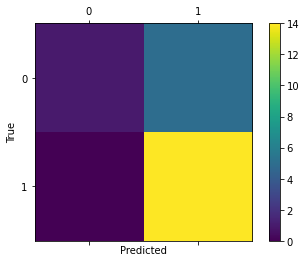

Logistic regression confusion matrix: 
[[ 4  2]
 [ 2 12]]


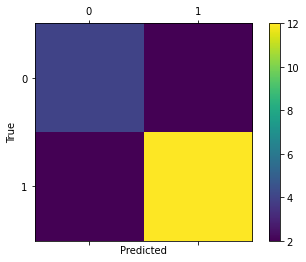

In [80]:
def plot_cm(cm, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

labels = ['0', '1']
print('Random forest confusion matrix: ')
cm_rf = confusion_matrix(y_test_st_1, pipeline_rf_st_1.predict(X_test_st_1))
print(cm_rf)
plot_cm(cm_rf, labels)

print('Logistic regression confusion matrix: ')
cm_lr = confusion_matrix(y_test_st_1, pipeline_lr_st_1.predict_proba(X_test_st_1)[:, 1] >= 0.5)
print(cm_lr)
plot_cm(cm_lr, labels)

## First stage conclusion

Even though random forest looks promising in average precision, the final performance is not that good: too many false positives; therefore I'll choose logistic regression as the better classifier here. It appears that the default threshold is adequate in terms of false positives, so we'll not change it.

## Stage 1 final model

In [87]:
model_st_1 = RandomizedSearchCV(*pipeline_w_param_dist('lr'), verbose=1, 
                                scoring=cv_scoring, cv=inner_stage_1, n_iter=300, n_jobs=-1)
model_st_1.fit(X_st_1, y_st_1)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   21.2s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('features',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                

In [98]:
test['label_first_stage'] = model_st_1.predict(test_text['text_baseline_cleaned'])
# also save the model
pickle_to_file(model_st_1, 'model_st_1')

## Second stage classification

In the second stage I'll reduce the hyperparameter search space by focusing on previously best parameters -> fitting only logistic regression models on Tf-Idf vectors with mid_df close to the previous best performing value. I will also forgo the train-test split to maximize the number of positive samples for the nested CV.

In [182]:
def second_pipeline_w_param_dist():
    tf_idf = TfidfVectorizer(max_features=None, ngram_range=(1,1))
    lr = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')

    pipe = Pipeline(steps=[
        ('features', tf_idf),
        ('clf', lr)
    ])
    
    param_dist = {
        'features__min_df': [0.24],
        'clf__C': scipy.stats.loguniform(1e-2, 1e+2)
    }

    return pipe, param_dist

In [183]:
X_st_2 = train_text[train_text.index.isin(train_second_stage.index)]['text_baseline_cleaned'].to_numpy()
y_st_2 = train_second_stage['label_second_stage'].to_numpy()

outer_stage_2 = StratifiedKFold(n_splits = 9, shuffle = True)
inner_stage_2 = StratifiedKFold(n_splits = 8, shuffle = True)
res_st_2 = hyperparam_search(X_st_2, y_st_2,
                             *second_pipeline_w_param_dist(),
                             outer_stage_2, inner_stage_2, 200)

print(res_st_2)

Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1577 out of 1600 | elapsed:   10.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1557 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1577 out of 1600 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    9.3s finished


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1554 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    9.5s finished


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1557 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    9.1s finished


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1554 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    9.6s finished


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    9.7s finished


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 8 folds for each of 200 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    8.8s finished


((Pipeline(memory=None,
         steps=[('features',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=0.24, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...'(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=0.8391615695633198,
                                    class_weight='balanced', dual=False,
          

In [228]:
print('LR AP: {0:.3f} +- {1:.3f}'.format(res_st_2[1].mean(), res_st_2[1].std()))

LR AP: 0.747 +- 0.360


In [236]:
def df_feature_weights(names, weights):
    df = pd.DataFrame({'names': names, 'weights': weights})
    return df.reindex(df.weights.abs().sort_values(ascending=False).index)

print('Feature weights for the second stage model: ')
print(df_feature_weights(res_st_2[0][0]['features'].get_feature_names(),
                         res_st_2[0][0]['clf'].coef_[0]).head(10))

print('Feature weights for the first stage model: ')
print(df_feature_weights(model_st_1.best_estimator_['features'].get_feature_names(),
                         model_st_1.best_estimator_['clf'].estimator.coef_[0]).head(15))

Feature weights for the second stage model: 
                 names   weights
98      tumorkonferenz  3.795686
17            chefarzt  1.302152
113     zusammenarbeit  0.000000
30                fall  0.000000
31              finden  0.000000
32                frau  0.000000
33   gastroenterologie  0.000000
34        geburtshilfe  0.000000
35      gefäßchirurgie  0.000000
36           gemeinsam  0.000000
Feature weights for the first stage model: 
               names     weights
74    tumorkonferenz  101.380751
4         anästhesie  -31.427107
17      diagnostisch   30.611708
50            modern   16.706036
29         gemeinsam   16.164485
3           ambulanz   16.131389
14          chefarzt   15.609380
85           wichtig  -15.370411
8         behandlung  -15.161948
26             frage  -14.646927
33         impressum   14.364864
75  tumorkonferenzen   12.596569
66           station  -10.736900
0          abteilung  -10.264076
20       durchführen   10.012076


## Second stage conclusion

Unfortunately all my attempts to train a meaningful model for the second stage have failed (the nested CV shows that the model fitting is extremely unstable, and the learned feature weights do not look meaningful for the second stage model). Therefore I will not submit any predictions for this stage in my submission.

In a real world scenario I would collect (and label by hand) more data for this task, and/or investigate oversampling techniques like SMOTE to hallucinate more minority class examples.

In [243]:
submission = test[['url', 'doc_id']].copy()
submission['label'] = test['label_first_stage'].apply(lambda x: 1 if x == 0 else 2)
submission.to_csv('submission.csv', index=False)

In [247]:
print('Mean time per sample: {:.3f} s'.format((22.8 / 2 + 24.5) / (len(train) + len(test))))

Mean time per sample: 0.243 s


# Final remarks

Algorithm speed: I do not consider model fitting time as part of the final algorithm runtime, and the inference time should be negligible, consequently the running time should be well approximated by html parsing time + text pre-processing time (calculated in the cell above; html parsing time is divided by two to account for the unused second parser). These steps could each be parallelized to improve performance.

I expect the model to perform well on the test data - cross-validation scores were fairly stable.

Possible improvements: more advanced features (doc2vec) could lead to better performance (if pre-trained on a sufficiently large additional corpus); data augmentation could also help; could find (train) a better language model for spaCy.

Potential issues (aside from not being able to detect class 3): I think the model is simple enough to be reliable, but perhaps new data could use an (almost) entirely different vocabulary and break the model.